# Machine Learning: Decision Tree

In [18]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from IPython.display import display, Latex, Markdown
import matplotlib.pyplot as plt

In [2]:
# gun violence cases dataset cleaned
cases = pd.read_csv('stage3.csv')
cases = cases.loc[:, ['date', 'state', 'n_killed', 'n_injured']]

cases['date'] = pd.to_datetime(cases['date'])
cases['year'] = cases['date'].dt.year
cases['harmed'] = cases['n_killed'] + cases['n_injured']
cases = cases.drop(columns=['date', 'n_killed', 'n_injured'])
cases = cases[(cases['year'] > 2013) & (cases['year'] < 2018)]
cases = cases.groupby(['state', 'year']).agg('sum')
cases = cases.reset_index()

# Check if gun cases were reduced based on previous year values (only valid for 2015-2017)
harmed = cases['harmed'].tolist()
change = list()

# True = Reduce, False = Increase
for i in range(0, len(harmed), 4):
    change.append(False)                           # Year 2014; Temporary Place-Holder
    change.append(harmed[i] > harmed[i+1])         # Year 2015
    change.append(harmed[i+1] > harmed[i+2])       # Year 2016
    change.append(harmed[i+2] > harmed[i+3])       # Year 2017

cases['change'] = pd.Series(change)
cases = cases.drop(labels=range(0, len(change), 4), axis=0)
cases = cases[(cases['state'] != 'District of Columbia')]
cases.head(5)

,state,year,harmed,change
1,Alabama,2015,947,False
2,Alabama,2016,1249,False
3,Alabama,2017,1400,False
5,Alaska,2015,154,False
6,Alaska,2016,191,False


`MR: Instead of using the raw count to compare, we should factor in state population on a yearly basis and compare the proportion of cases 
alongside the population increase/decrease (ex. #cases in Alabama 2015/ population count Alabama 2015)`


`to stay consistent should we also do > 2014 in the cases dataset`

In [3]:
#  gun laws dataset cleaned
laws = pd.read_csv('statefirearmlaws.csv')
laws = laws[(laws['year'] > 2014) & (laws['year'] < 2018)]
laws.head(5)

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
24,Alabama,2015,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
25,Alabama,2016,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
26,Alabama,2017,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,10
54,Alaska,2015,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
55,Alaska,2016,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [4]:
# Combined dataset
data = cases.merge(laws, on=['state', 'year'], how='outer')
data = data.drop(columns=['year', 'harmed', 'lawtotal']) #i think we should keep all these columns
data.head(5)

,state,change,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,exparte,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking
0,Alabama,False,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Alabama,False,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Alabama,False,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Alaska,False,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alaska,False,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create the features and labels for classification.

In [5]:
def create_features_labels(dataset):
    X = dataset.iloc[:, 2:]    # Features are all categories of gun laws
    y = dataset['change']      # Labels are if the number of cases reduced
    y = y.replace({True: 1, False: 0})
    return X, y

X, y = create_features_labels(data)

`MR: instead of change, we should use the target label: decrease as in decrease in the number of cases since that is ultimately what we want to observe`

Create a baseline classifier `MajorityLabelClassifier` to test our classifier against. This will always predict the class equal to the mode of the labels.

In [6]:
class MajorityLabelClassifier():
    # Initialize parameter for the classifier
    def __init__(self):
        self.mode = 0
    
    # Fit the data by taking training data X and their labels y and storing the learned parameter
    def fit(self, X, y):
        modes = dict()           # Stores all the modes of the training data
        y = y.tolist()
        for i in range(len(X)):
            if y[i] in modes.keys():
                modes[y[i]] += 1
            else:
                modes[y[i]] = 1
                
        # Find the most frequent mode and store it
        total = 0
        for key in modes:
            if modes[key] > total:
                total = modes[key]
                self.mode = key
    
    # Predict the label for each instance X as the learned parameter
    def predict(self, X):
        labels = list()
        for i in X:
            labels.append(self.mode)
        return labels
    
    # Calculate the accuracy of our classifier using the true and predicted labels
    def evaluate_accuracy(self, y, y_predict):
        accurate_pred = 0
        total = len(y_predict)
        true_labels = y.tolist()
        
        for i in range(total):
            if true_labels[i] == y_predict[i]:
                accurate_pred += 1
        return accurate_pred/total

In [7]:
baseline = MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.7089552238805971


Evaluate the `DecisionTreeClassifier()` by training, fitting, and predicting on the data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=1)
clf_model = DecisionTreeClassifier()   
clf_model.fit(X_train,y_train)
y_predict = clf_model.predict(X_test)
clf_model.score(X,y)

0.7466666666666667

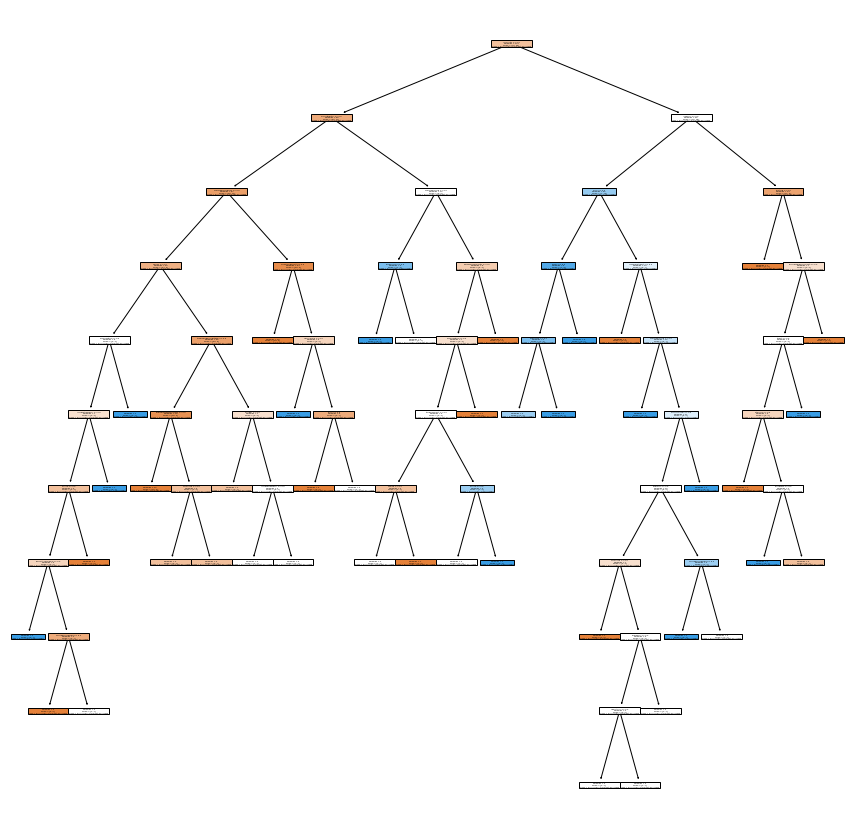

In [19]:
feature_names_list = list(X.columns) #a list of column names from merged gun incident and reform dataset, in order; currently features are types of gun laws
plt.figure(figsize=(15,15))
plot_tree(clf_model, feature_names = feature_names_list,  
            class_names = ['Gun Violence Did Not Decrease', 'Gun Violence Decreased'], 
            filled = True, impurity = False); #class names match to `decrease` values [0=did not decrease, 1=did decrease]

`we should use cross validation to fine tune some of our parameters and try to increase our accuracy up to 80%`

To Do (04/02/2022):
- add state population counts and use proportions instead of raw counts to compare decrease in gun violence
- change target label to 'decrease'
- put MajorityLabelClassifier class in a .py file of its own and just import to avoid going over 5 page limit
- fine tune parameters on DT using cross validation (ex. depth of decision tree)
- visualize decisision tree with sklearn function